In [33]:
try:
    %tensorflow_version 2.x
except:
    pass

import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [34]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [35]:
# data_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
# target = 'fashion-mnist'
# cache_dir = None

# if cache_dir and not os.path.exists(cache_dir):
#     os.mkdir(cache_dir)
    
# data_file = tf.keras.utils.get_file('fashion_mnist.gz',
#                                     'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
#                                     extract=True)

In [36]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, metadata = tfds.load('fashion_mnist', as_supervised=False, with_info=True)

In [37]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [38]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [39]:
def normalize(element):
    image = element['image']
    image = tf.cast(image, tf.float32)
    image /= 255
    return image

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

In [58]:
BATCH_SIZE=64
train_dataset =  train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset  =  test_dataset.cache()

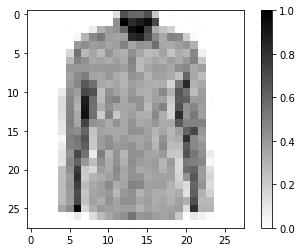

In [59]:
def display_image(image):
    image = image.numpy().reshape((28,28))
    plt.figure()
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

for image in test_dataset.take(1):
    display_image(image)

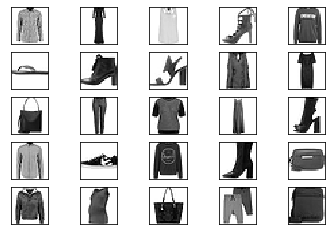

In [60]:
def display_images(images):
    plt.figure()
    i = 0
    for image in images:
        image = image.numpy().reshape((28,28))
        plt.subplot(np.ceil(len(images)/5),5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
    plt.show()
    
display_images(list(test_dataset.take(25)))

In [61]:
latent_dim = 10

In [89]:
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(name='encoder',
            layers = [
              tf.keras.layers.InputLayer(input_shape=(28, 28, 1), name='encoder/input'),
              tf.keras.layers.Conv2D(
                  filters=32, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv1'),
              tf.keras.layers.Conv2D(
                  filters=64, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv2'),
              tf.keras.layers.Flatten(name='encoder/flatten'),
              tf.keras.layers.Dense(latent_dim, name='encoder/bottleneck'),]
        )
        
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim), name='decoder/input'),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu, name='decoder/dense1'),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32), name='decoder/reshape'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv1'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv2'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, 
              kernel_size=3, 
              strides=(1, 1), 
              padding='same', 
              name='decoder/deconv3'),])

    def call(self, inputs):
        z = self.encoder(inputs)
        x = self.decoder(z)
        return x
        
    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def loss(self, x, y):
        return tf.keras.losses.MeanSquaredError(x, x)

In [91]:
model = ConvAutoEncoder(latent_dim=50)

In [105]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy)

In [109]:
n_epochs = 5
model.fit(train_dataset, train_dataset, epochs=n_epochs, steps_per_epoch=np.ceil(num_train_examples/BATCH_SIZE))

ValueError: You passed a dataset or dataset iterator (<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>) as input `x` to your model. In that case, you should not specify a target (`y`) argument, since the dataset or dataset iterator generates both input data and target data. Received: <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>